# import

In [1]:
import numpy as np
import pandas as pd
# import scipy.io
# from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from tqdm import tqdm
import os
import pickle

%load_ext autoreload
%autoreload 2

In [4]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

# load grat1

In [3]:
data_dir_grat = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1372_220714_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(data_dir_grat, vis_filter=False)
stim_id = stim_id[:trace_by_trial.shape[1]] # truncate to uncorrupted trials
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

ncell: 56, nstim: 1, ntrial: 219, nframe: 267
trace_cell_avg: (267,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (267,)


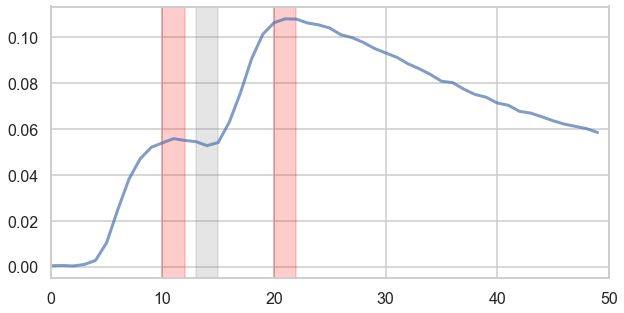

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(10, 12, alpha=0.2, color='red')
ax.axvspan(13, 15, alpha=0.2, color='gray')
ax.axvspan(20, 22, alpha=0.2, color='red')
plt.xlim(0, 50);

# adp stability
estimate how many trials to group together to get a stable adaptation value  
1. trace_by_trial shape: ncell x ntrial x nframe  
2. for each cell x trial, get resp_ad and resp_tg  
3. for whole population, loop thru trial numbers to group together to get a stable adaptation value  
3.1 measure adp value stability: plot group_size vs adp_mean & adp_std  
4. do this for each cell  
4.1 distribution of stable_group_size among cells  

In [5]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,10:12+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:15+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

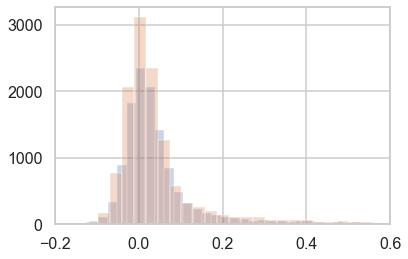

In [8]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

In [9]:
# # cap resp to thres_perc percentile of trials

# thres_perc = 1
# low, high = np.percentile(resp_ad.flatten(), [thres_perc, 100-thres_perc])
# resp_ad = np.clip(resp_ad, low, high)
# plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');

# low, high = np.percentile(resp_tg.flatten(), [thres_perc, 100-thres_perc])
# resp_tg = np.clip(resp_tg, low, high)
# plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');


## pop adp stability
population of 56 cells need 10-20 trials to get a stable adaptation value  
regardless of using mean or median to aggregate  
but using median gets abs larger adp value than mean

In [19]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((219,), -0.3218938759212324, -0.11172270297723275)

In [20]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 2):
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

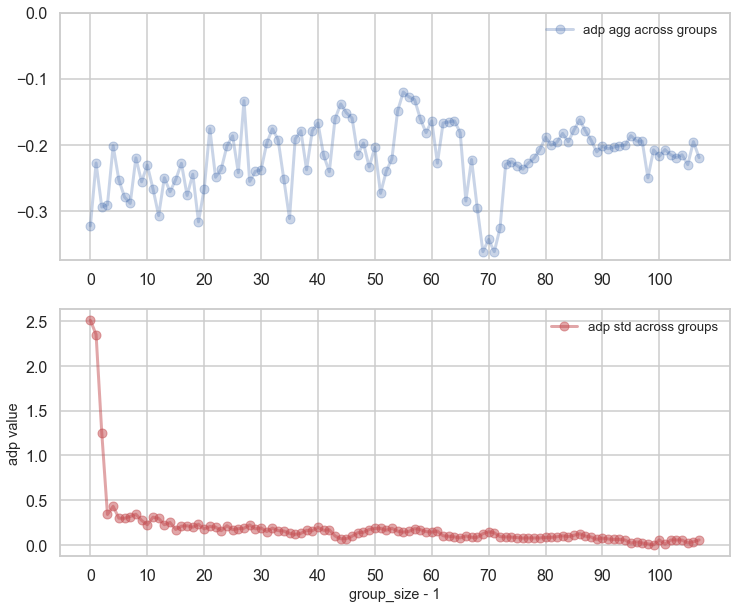

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_agg, 'o-', color='b', linewidth=3, alpha=0.3, label='adp agg across groups')
# plt.axhline(-0.32, color='g')
plt.xticks(np.arange(0,110,10))
plt.ylim(plt.ylim()[0], 0)
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
# plt.ylim(0, 0.5)
plt.ylabel('adp value')
plt.legend(frameon=False);

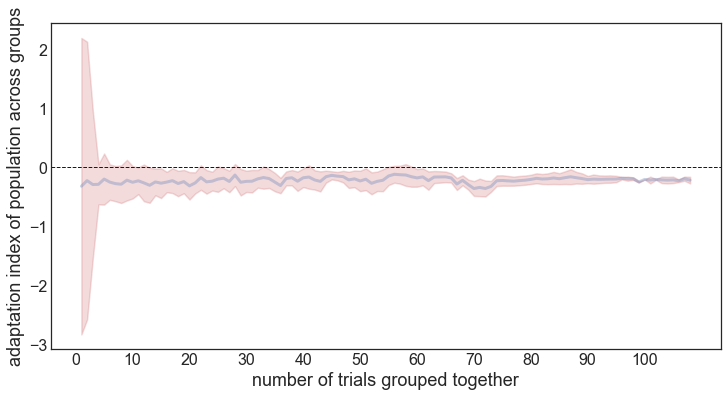

In [65]:
errbar = adp_std # adp_sem 
x = np.arange(1, adp_agg.shape[0]+1)

plt.style.use('seaborn-white')

fig = plt.figure(figsize=(12, 6))
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index of population across groups', fontsize=18); #  across groups of different sizes

## single cell adp stability
single cells need 20-30 trials to get a stable adaptation value  

In [29]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

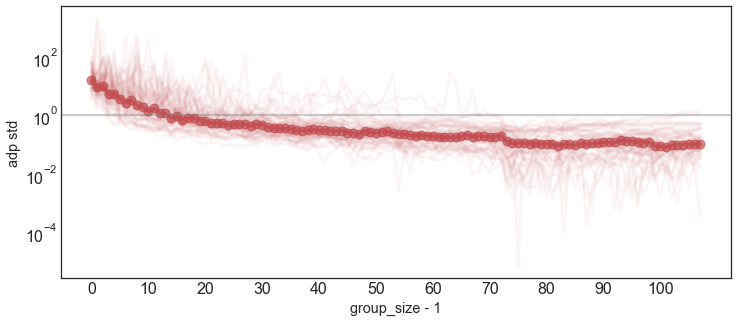

In [35]:
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_agg, 'o-', color='r', linewidth=3, alpha=0.7, label='adp std across groups, agg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.axhline(1, alpha=0.4, color='gray')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
# plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('adp std');

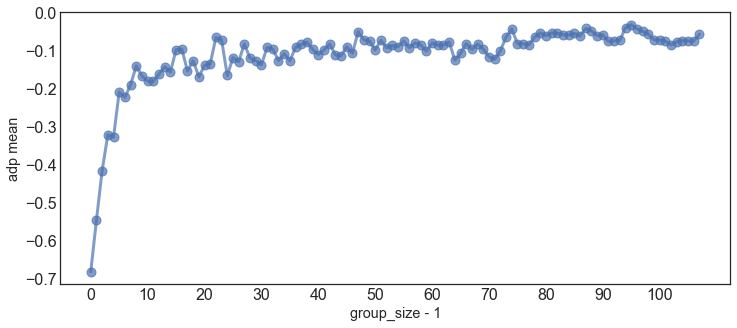

In [36]:
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_agg_agg, 'o-', color='b', linewidth=3, alpha=0.7, label='adp agg across groups, agg over cells')
# for icell in np.arange(ncell):
#     plt.plot(adp_cell_agg[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp agg across groups')

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
# plt.ylim(-0.5,1)
plt.ylabel('adp mean');

In [ ]:
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index of population', fontsize=18);

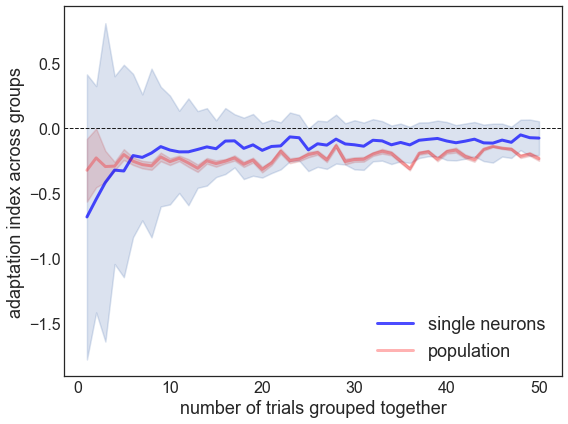

<Figure size 432x288 with 0 Axes>

In [70]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 50

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
fig.savefig(os.path.join(figpath, 'adp_stability_group_trials.pdf'), format='pdf')

# load mix50
mix50 stim: Z:\All_Staff\home\lan\Mwork\mix50 - bunnytop high lum contrast mix grating and noise\Image

ncell: 169, nstim: 50, ntrial: 1473, nframe: 203
trace_cell_avg: (203,).         trace_stim_avg list len: 50.         trace_stim_avg[0].shape: (203,)


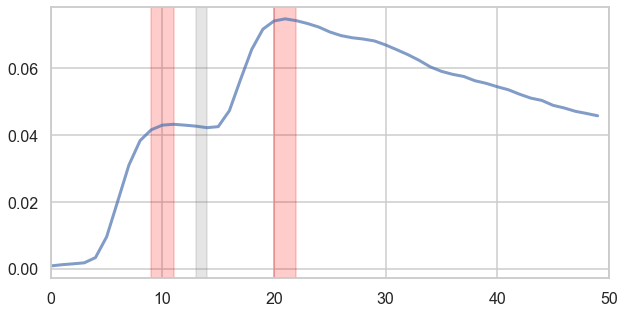

In [6]:
imouse = 'i1373'
date = '220909'
area = 'V1'

if local_flag:
    data_dir = r'D:\repo\inter_data\mix50\V1_i1373_220909_cellpose'
else:
    data_dir = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/' + area + '_' + imouse + '_' + date + '_cellpose/'

stim_id, trace_by_trial = adp.load_trace_trial_data(data_dir, vis_filter=True)
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(9,11, alpha=0.2, color='red')
ax.axvspan(13,14, alpha=0.2, color='gray')
ax.axvspan(20,22, alpha=0.2, color='red')
plt.xlim(0, 50);

# trace by stim / type

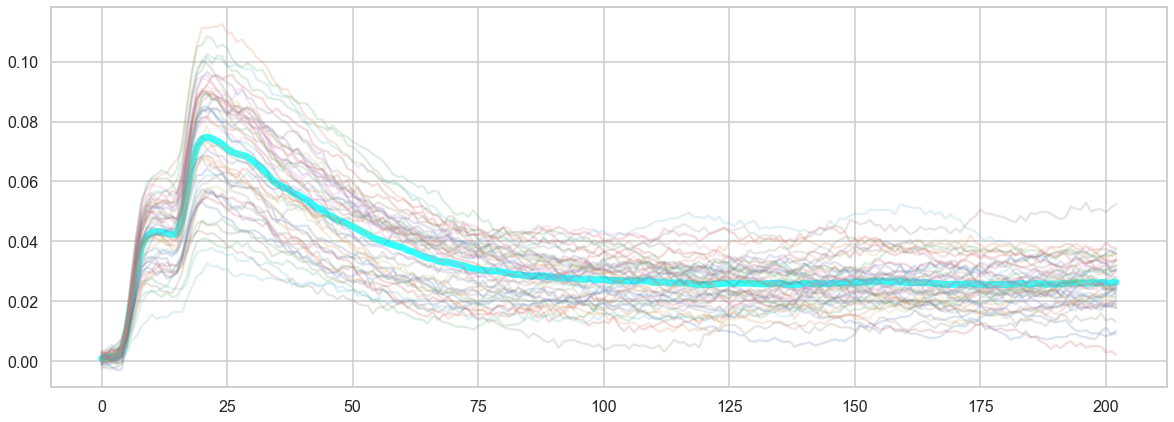

In [7]:
# plot trace for each stim
plt.figure(figsize=(20, 7))
plt.plot(trace_avg_cell, alpha=0.8, linewidth=7, color='cyan')
for i in np.unique(stim_id)-1:
    plt.plot(trace_stim_avg[i], alpha=0.2)

In [8]:
# plot trace for stim 1-30 (natural) vs stim 31-40 (grat) vs stim 41-50 (noise)

stim_type_dict = {'natural': [np.arange(1, 30+1)], 
                  'grat': [np.arange(31, 40+1)], 
                  'noise': [np.arange(41, 50+1)]}
for key in stim_type_dict.keys():
    print(key, np.min(stim_type_dict[key]), '-', np.max(stim_type_dict[key]))
    
trace_type_avg = []
trace_type_std = []
trace_type_sem = []

for key in stim_type_dict.keys():
    
    trace_itype_avg = np.mean(trace_by_trial[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]], axis=1) # ncell x nframe
    trace_itype_avg = np.mean(trace_itype_avg, axis=0) # nframe
    trace_itype_std = np.std(trace_by_trial[:, np.where((np.isin(stim_id, stim_type_dict[key])))[0]], axis=1)
    trace_itype_std = np.mean(trace_itype_std, axis=0)
    trace_itype_sem = trace_itype_std / np.sqrt(len(np.where((np.isin(stim_id, stim_type_dict[key])))[0]))

    trace_type_avg.append(trace_itype_avg)
    trace_type_std.append(trace_itype_std)
    trace_type_sem.append(trace_itype_sem)

len(trace_type_avg), trace_type_avg[0].shape

natural 1 - 30
grat 31 - 40
noise 41 - 50


(3, (203,))

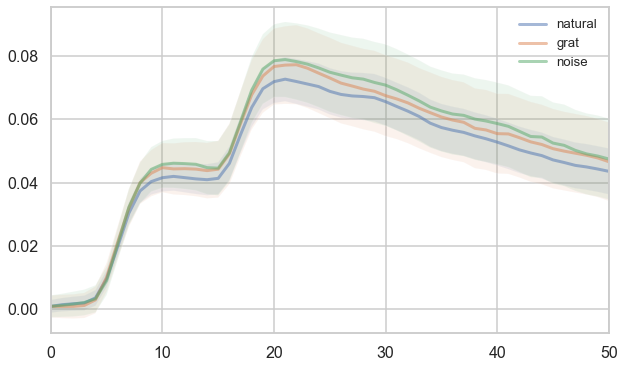

In [9]:
# plot trace for each stim type
plt.figure(figsize=(10, 6))

for i in np.arange(len(stim_type_dict.keys())):
    plt.plot(trace_type_avg[i], alpha=0.5, linewidth=3, label=list(stim_type_dict.keys())[i])
    errbar = trace_type_sem[i]
    plt.fill_between(np.arange(len(trace_type_avg[i])), 
                 trace_type_avg[i] + errbar, trace_type_avg[i] - errbar, 
                 alpha=0.1, label='')

plt.xlim(0,50)
plt.legend(frameon=False);

# resp ad vs tg

In [10]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

resp_ad.shape, resp_tg.shape

((169, 1473), (169, 1473))

# feature matrix for decoding branch

In [384]:
feature_mat = np.concatenate((resp_ad.T, resp_tg.T), axis=0)
feature_mat.shape # ntrial x ncell. doubled ntrial bc we now count ad and tg as separate trials

feature_df = pd.DataFrame(feature_mat)
feature_df.columns = [f'{date}_cell_' + str(i) for i in np.arange(feature_mat.shape[1])] # name columns

image_id = stim_id + stim_id # pass thru adapter stim id and target stim id. they are identical
feature_df['image_index'] = image_id

feature_df['repeat_number'] = [0] * len(stim_id) + [1] * len(stim_id) # first show of an image is not a repeat, repeat_number = 0
feature_df['is_change'] = feature_df['repeat_number'].astype('bool')
feature_df['is_change'] = ~feature_df['is_change'] # repeat_number = 0 means is_change = True (R1)

feature_df

,220909_cell_0,220909_cell_1,220909_cell_2,220909_cell_3,220909_cell_4,220909_cell_5,220909_cell_6,220909_cell_7,220909_cell_8,220909_cell_9,...,220909_cell_162,220909_cell_163,220909_cell_164,220909_cell_165,220909_cell_166,220909_cell_167,220909_cell_168,image_index,repeat_number,is_change
0,0.085099,0.066981,0.052889,-0.062783,-0.002253,0.007776,0.122258,-0.002174,-0.110661,-0.024588,...,-0.004557,-0.018687,-0.067637,-0.027928,0.016667,-0.112769,-0.051802,32,0,True
1,-0.073126,-0.060032,0.043891,0.110740,0.038231,0.229996,-0.080868,0.078974,0.048725,0.112395,...,-0.031547,0.025655,0.049019,0.112233,-0.019340,0.026793,-0.116765,45,0,True
2,-0.001636,-0.131840,0.049660,0.077684,0.062475,-0.083150,0.041879,0.022966,0.044662,0.107028,...,0.066555,-0.038453,0.095623,0.062084,-0.032760,0.004245,0.008030,7,0,True
3,-0.090922,0.017874,0.144421,0.144446,0.021053,0.276543,0.025017,0.116913,0.056795,0.351545,...,0.019855,-0.050687,-0.058655,0.114928,0.012749,-0.108263,-0.158842,49,0,True
4,0.045601,-0.031081,0.203166,-0.015657,0.066467,0.234561,0.002094,0.122033,0.084428,0.343762,...,0.027894,-0.022153,-0.090181,-0.008874,0.006685,-0.003503,-0.154210,47,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2941,0.114849,0.028904,0.100147,-0.077534,0.129256,-0.126236,0.114113,-0.001369,-0.013343,0.022889,...,0.081073,0.025550,0.028613,-0.022261,-0.003858,-0.074654,0.034964,5,1,False
2942,0.038060,0.100186,-0.045349,0.383678,-0.021635,0.010497,-0.033711,0.007276,0.069433,-0.024648,...,0.023547,-0.017232,0.008047,0.072719,-0.037117,-0.003861,0.040530,14,1,False
2943,-0.022358,0.095172,0.109542,0.012098,0.016840,-0.023606,0.035470,-0.105930,-0.062366,-0.055915,...,0.076214,0.025192,-0.050226,-0.064673,0.017606,0.032510,0.042925,21,1,False
2944,0.010572,0.029450,0.030251,-0.081950,0.045679,0.107376,-0.083510,-0.018734,-0.012034,-0.011190,...,0.050810,0.032355,0.028045,0.023743,0.028884,0.057239,0.008125,31,1,False


In [386]:
feature_df.groupby(['repeat_number', 'image_index']).count()#.get_group((0, 1))

220909_cell_0  220909_cell_1  220909_cell_2  \
repeat_number image_index                                                
0             1                       30             30             30   
              2                       30             30             30   
              3                       29             29             29   
              4                       30             30             30   
              5                       30             30             30   
...                                  ...            ...            ...   
1             46                      30             30             30   
              47                      29             29             29   
              48                      29             29             29   
              49                      30             30             30   
              50                      29             29             29   

                           220909_cell_3  220909_cell_4  220909_cell_5  \
repeat_number image_index                                                
0             1                       30             30             30   
              2                       30             30             30   
              3                       29             29             29   
              4                       30             30             30   
              5                       30             30             30   
...                                  ...            ...            ...   
1             46                      30             30             30   
              47                      29             29             29   
              48                      29             29             29   
              49                      30             30             30   
              50                      29             29             29   

                           220909_cell_6  220909_cell_7  220909_cell_8  \
repeat_number image_index                                                
0             1                       30             30             30   
              2                       30             30             30   
              3                       29             29             29   
              4                       30             30             30   
              5                       30             30             30   
...                                  ...            ...            ...   
1             46                      30             30             30   
              47                      29             29             29   
              48                      29             29             29   
              49                      30             30             30   
              50                      29             29             29   

                           220909_cell_9  ...  220909_cell_160  \
repeat_number image_index                 ...                    
0             1                       30  ...               30   
              2                       30  ...               30   
              3                       29  ...               29   
              4                       30  ...               30   
              5                       30  ...               30   
...                                  ...  ...              ...   
1             46                      30  ...               30   
              47                      29  ...               29   
              48                      29  ...               29   
              49                      30  ...               30   
              50                      29  ...               29   

                           220909_cell_161  220909_cell_162  220909_cell_163  \
repeat_number image_index                                                      
0             1                         30               30               30   
              2                        

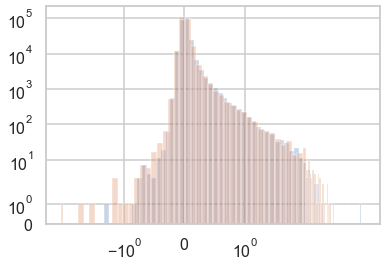

In [10]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xscale('symlog')
plt.yscale('symlog')

In [11]:
# # set extreme percentile resp to nan

# thres_perc_low = 0.5
# thres_perc_high = 0.5
# low, high = np.percentile(resp_ad.flatten(), [thres_perc_low, 100-thres_perc_high])
# # resp_ad = np.clip(resp_ad, low, high)
# resp_ad[resp_ad < low] = np.nan
# resp_ad[resp_ad > high] = np.nan
# plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');

# low, high = np.percentile(resp_tg.flatten(), [thres_perc, 100-thres_perc])
# # resp_tg = np.clip(resp_tg, low, high)
# resp_tg[resp_tg < low] = np.nan
# resp_tg[resp_tg > high] = np.nan
# plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG')
# plt.legend();

## adp or resp corr btw stim

766.57 -10407.48
15.56 -14.88


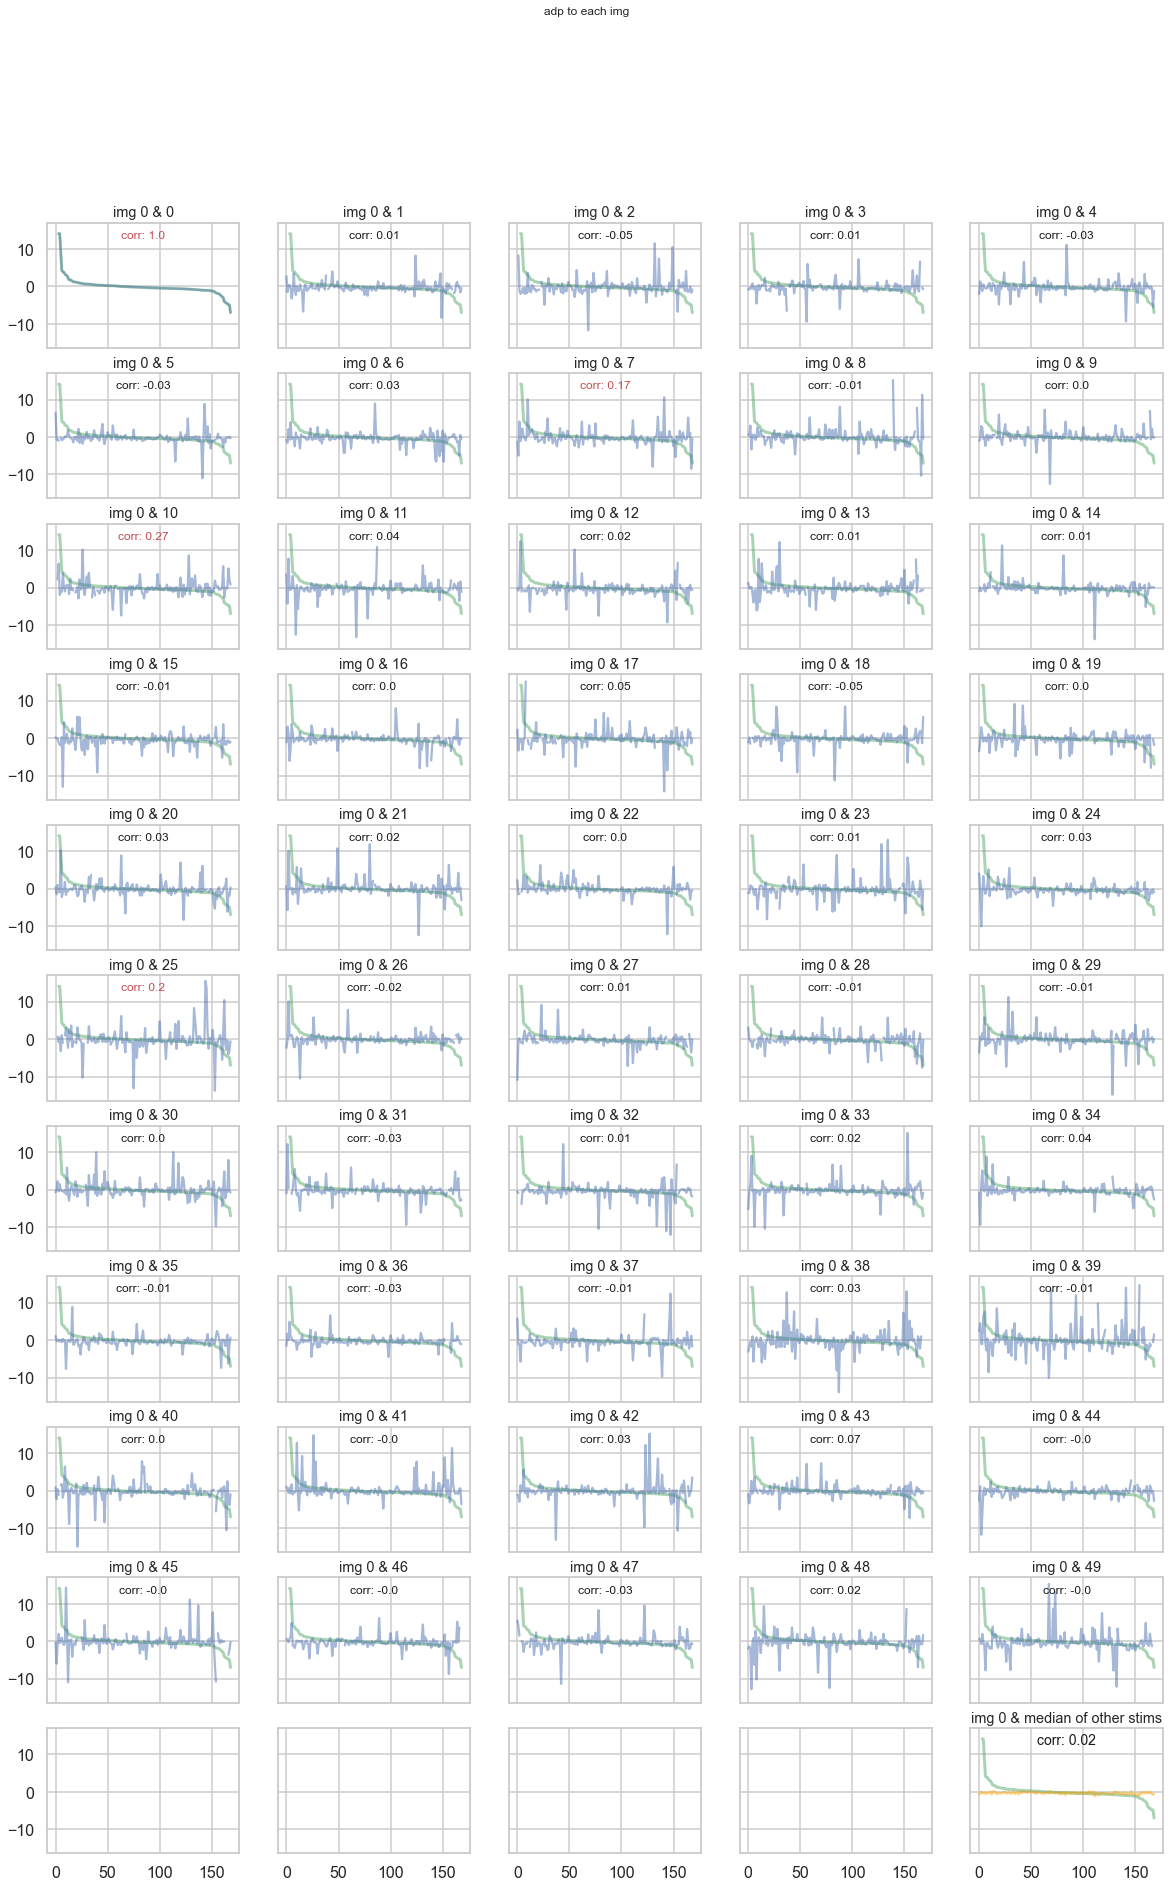

In [432]:
R1_R2_avg = feature_df.groupby(['image_index', 'repeat_number']).mean().reset_index() # avg R1 & R2 for each img, each neuron
non_neuron_columns = ['image_index', 'repeat_number', 'is_change'] # in our data, cell id col name are also strings
R1_avg = R1_R2_avg[R1_R2_avg.repeat_number == 0].drop(non_neuron_columns, axis=1).reset_index(drop=True).to_numpy()
R2_avg = R1_R2_avg[R1_R2_avg.repeat_number == 1].drop(non_neuron_columns, axis=1).reset_index(drop=True).to_numpy()
adp_img = (R2_avg - R1_avg) / (R1_avg + 1e-7) # adp for each img (trial already grouped), each neuron
nstim = feature_df.image_index.unique().shape[0] # use trials_to_keep to get nstim, bc in full data exists img_id=8 where repeat_number=nan

def plot_sorted_cells(adp_img, title_str):
    # for each row in adp_img, mask cells with extreme values by percentile
    adp_img_masked = np.ma.masked_where(adp_img > np.percentile(adp_img, 99), adp_img)
    adp_img_masked = np.ma.masked_where(adp_img_masked < np.percentile(adp_img_masked, 1), adp_img_masked)
    print(np.amax(adp_img).round(2), np.amin(adp_img).round(2))
    print(np.amax(adp_img_masked).round(2), np.amin(adp_img_masked).round(2))

    adp_sorted_idx = np.argsort(adp_img_masked[0, :]) # cell sorted by adp to img 0
    adp_sorted_idx = adp_sorted_idx[::-1] # argsort from large to small, so reverse the order

    # make subplots for each img pair: img 0 vs img 1, img 0 vs img 2, etc
    fig, axs = plt.subplots(11, 5, figsize=(20, 30), sharex=True, sharey=True)
    plt.suptitle(title_str)
    adp_stim0 = adp_img_masked[0, adp_sorted_idx].round(2)
    corr_to_stim0 = np.ones((nstim, 1))

    for istim in np.arange(nstim):
        adp_stim = adp_img_masked[istim, adp_sorted_idx]
        corr = np.corrcoef(adp_stim0, adp_stim)[0, 1]
        color_str = 'k' if corr < 0.1 else 'r'
        corr_to_stim0[istim] = corr
        axs[istim // 5, istim % 5].text(0.5, 0.9, 'corr: ' + str(corr.round(2)), horizontalalignment='center', verticalalignment='center', transform=axs[istim // 5, istim % 5].transAxes, color=color_str, fontsize=12)
        
        axs[istim // 5, istim % 5].plot(adp_stim0, label=str(0), alpha=0.5, color='g', linewidth=3)
        axs[istim // 5, istim % 5].plot(adp_stim, label=str(istim), alpha=0.5)
        axs[istim // 5, istim % 5].set_title('img 0 & ' + str(istim))
    # TODO: sort cells by adp avg over all trials, then plot adp to each img

    adp_stim_other = np.ma.median(adp_img_masked[1:, adp_sorted_idx], axis=0)
    # print(np.round(adp_stim_other, 2))
    corr = np.corrcoef(adp_stim0, adp_stim_other)[0, 1]
    color_str = 'k' if corr < 0.1 else 'r'
    axs[10, 4].text(0.5, 0.9, 'corr: ' + str(corr.round(2)), horizontalalignment='center', verticalalignment='center', transform=axs[10, 4].transAxes, color=color_str, fontsize=14)
    axs[10, 4].plot(adp_stim0, label=str(0), alpha=0.5, color='g', linewidth=3)
    axs[10, 4].plot(adp_stim_other, label='other', alpha=0.5, color='orange')
    axs[10, 4].set_title('img 0 & median of other stims') # final subplot: median resp to all stim except 0
    # plt.tight_layout()

    return corr_to_stim0

corr_to_stim0_adp = plot_sorted_cells(adp_img, 'adp to each img')

0.77 -0.06
0.3 -0.02


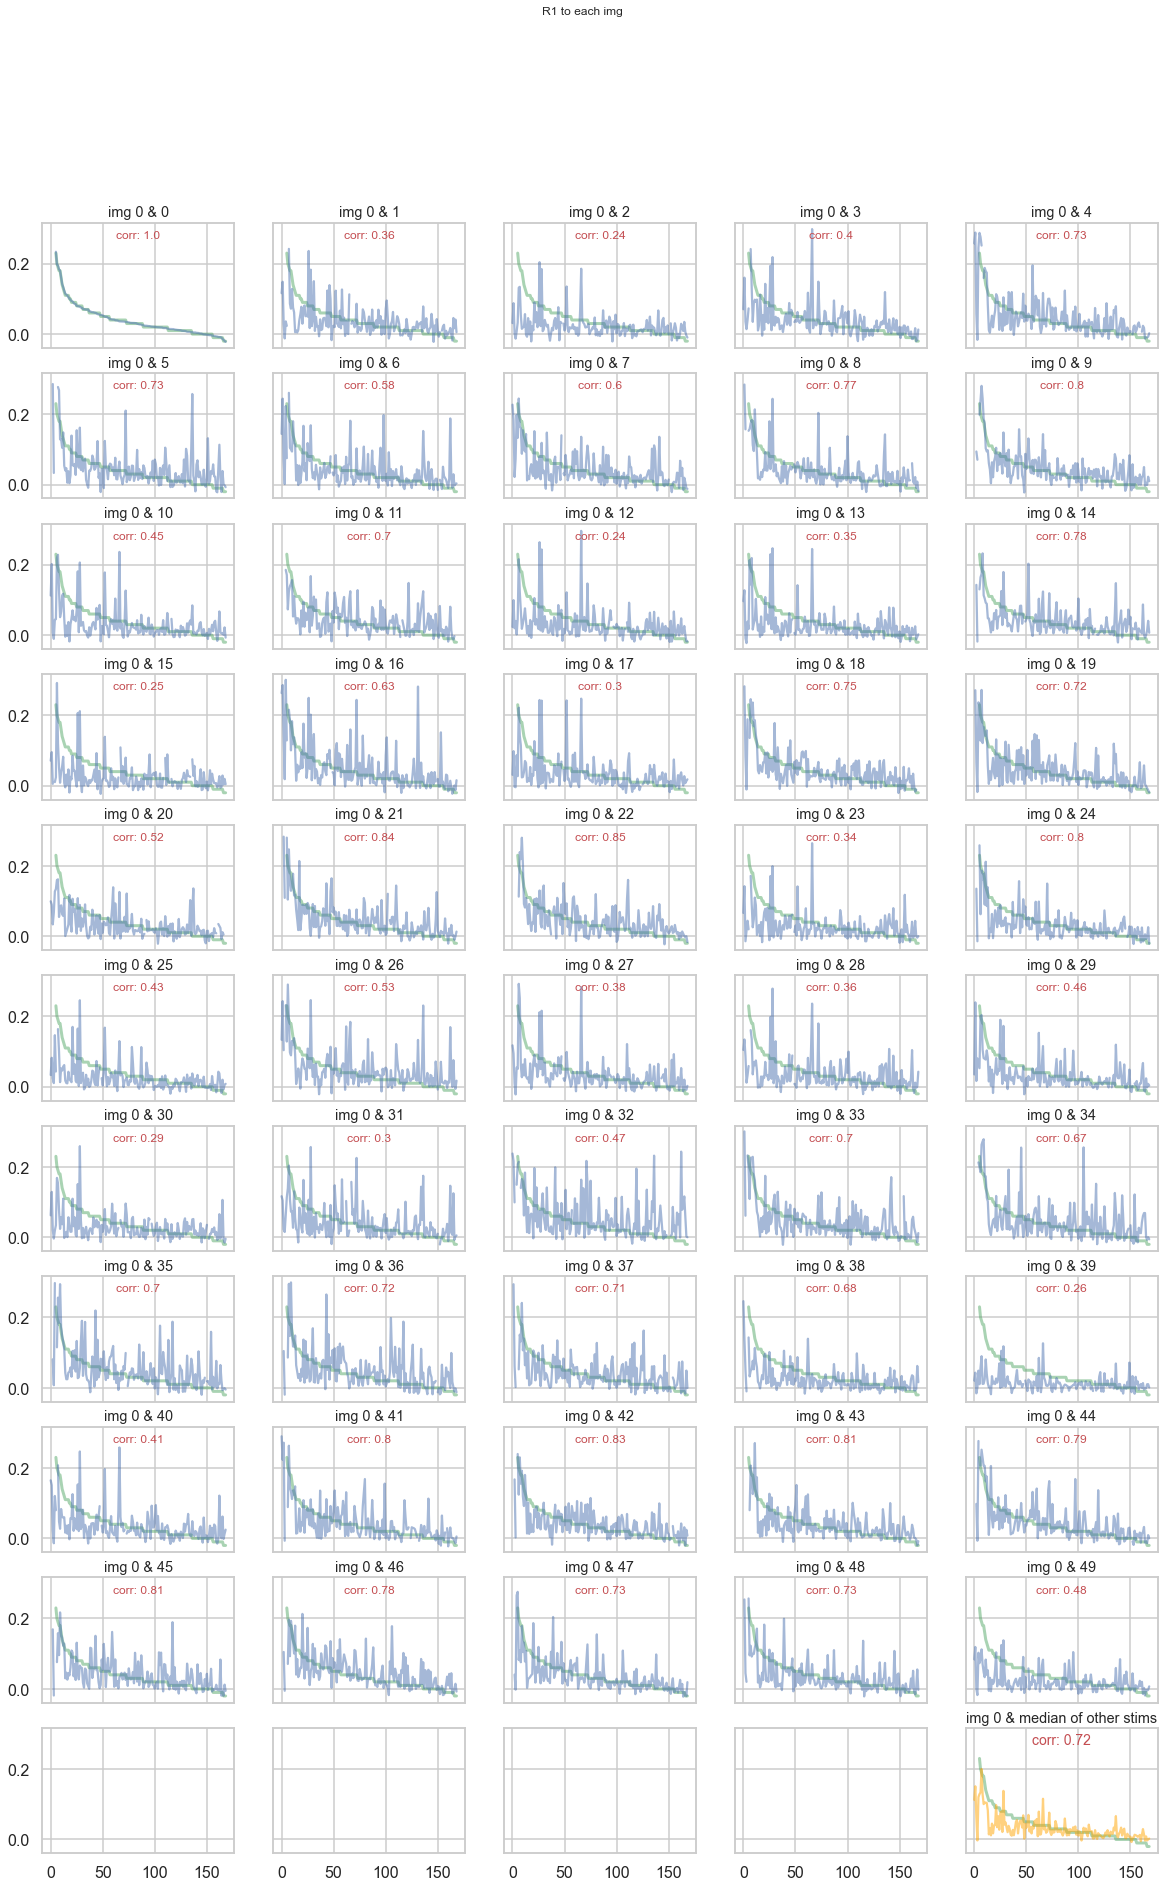

In [433]:
corr_to_stim0_R1 = plot_sorted_cells(R1_avg, 'R1 to each img')

0.78 -0.12
0.22 -0.02


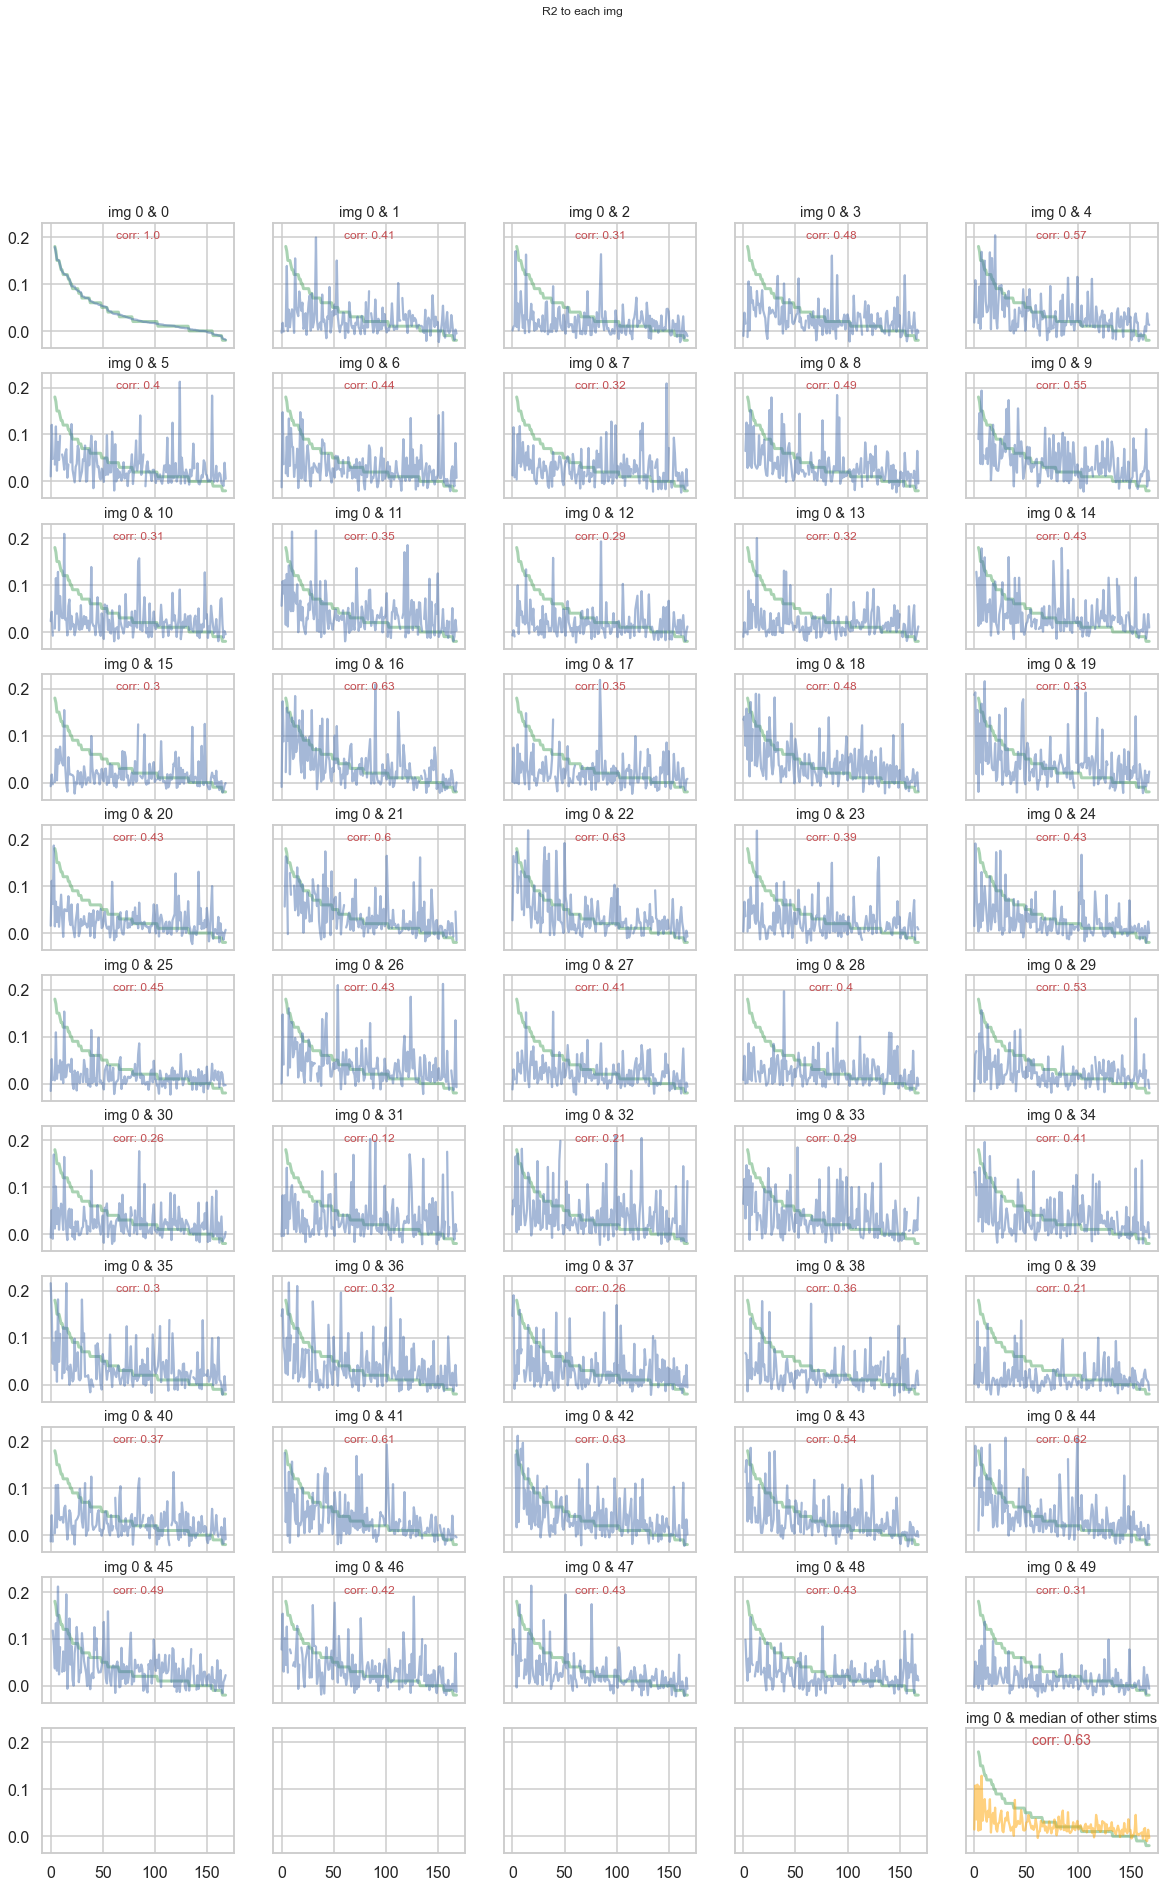

In [434]:
corr_to_stim0_R2 = plot_sorted_cells(R2_avg, 'R2 to each img')

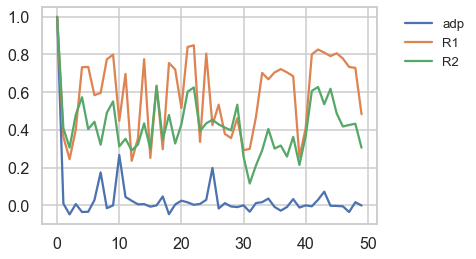

In [437]:
# migrated from https://github.com/lanluo9/dim_red_decoding/blob/master/code/dim_red.ipynb

# question: 
# are response patterns more separable post adaptation?
# do sparseness increase after adaptation?

# method:
# sort cells by response to image #1    
# plot response pattern to image #2  
# do this for: pre vs post adaptation, diff image pairs  
# compare: pearson correlation of sorted cell response vector

# result:
# no obvious decrease in correlation after adaptation
# TODO: check diff img pair combinations, check diff istim vs other, avg over all img pairs

plt.plot(corr_to_stim0_adp, label='adp')
plt.plot(corr_to_stim0_R1, label='R1')
plt.plot(corr_to_stim0_R2, label='R2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# adp
## adp by stim type: agg over all cell all trial

previous adp def  

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline  
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum  
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

In [11]:
agg_fun = np.nansum

resp_ad_pop = agg_fun(resp_ad, axis=0) # population response as agg of all cells for each trial
resp_tg_pop = agg_fun(resp_tg, axis=0)

df = pd.DataFrame()
df['stim_id'] = stim_id
df['stim_type'] = np.where(np.isin(stim_id, stim_type_dict['natural']), 'natural',
                  np.where(np.isin(stim_id, stim_type_dict['grat']), 'grat',
                  np.where(np.isin(stim_id, stim_type_dict['noise']), 'noise', 'other')))
df['resp_ad_pop'] = resp_ad_pop
df['resp_tg_pop'] = resp_tg_pop
# df = df.sort_values(by=['stim_id'])
# df

df_pop = df.groupby('stim_type').sum() # agg pop resp of all trials for each stim type
df_pop['adp_pop_type'] = (df_pop['resp_tg_pop'] - df_pop['resp_ad_pop']) / (df_pop['resp_ad_pop'] + 1e-7)
df_pop

,stim_id,resp_ad_pop,resp_tg_pop,adp_pop_type
stim_type,,,,
grat,10329,2123.134664,1624.032467,-0.235078
natural,13707,5977.808428,4659.929439,-0.220462
noise,13505,2215.997227,1672.009905,-0.245482


## vis, img driven, pref filter

In [40]:
# associate w spatial freq after bootstrap. calc pop resp w img_driven filter

data_dir = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1373_220909_cellpose'
# data_dir = r'D:\repo\inter_data\mix50\V1_i1373_220909_cellpose'
with open(data_dir + "/vis_driven.pickle", "rb") as handle:
    vis = pickle.load(handle)
# vis.keys()

vis_driven = vis["vis_driven"]
vis_driven = [v[0] for v in vis_driven]
img_driven = vis['img_driven'][vis_driven, :] # filter out non-vis driven cells. match shape of resp_ad
# img_driven.shape

# do img driven cells add up to vis driven cells? no.
np.sum(img_driven, axis=1) # nimg that drive each cell
ncell_img_driven = np.sum(np.sum(img_driven, axis=1) > 0) # ncell that are img driven
ncell_img_driven < np.sum(vis_driven) # some vis driven cells are not img driven! 
# TODO: adjust vis_driven criteria: lindsey uses union of img driven cells

cell_filter_name = 'pref_filter'
print(cell_filter_name)
if cell_filter_name == 'img_driven': # only use img driven cells
    cell_filter = vis['img_driven'][vis_driven, :]
elif cell_filter_name == 'pref_filter': # only use cells preferring each img
    pref_filter = np.load(data_dir + "/pref_filter.npy") # load pref_filter.npy, constructed under img driven filter
    cell_filter = pref_filter.copy().T
elif cell_filter_name == 'vis': # use all vis driven cells
    cell_filter = np.ones_like(img_driven)
else:
    raise ValueError('cell_filter not recognized')

pref_filter


(169, 50)
4 out of 50 stims have no cells passing filter
41 out of 169 cells have no stim passing filter


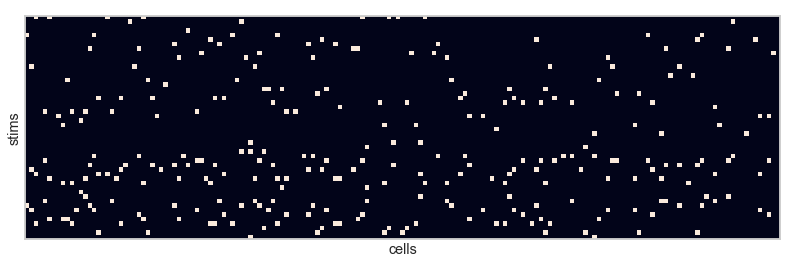

In [41]:
plt.matshow(cell_filter.T)
plt.xticks([]) # no axis ticks
plt.yticks([])
plt.xlabel('cells')
plt.ylabel('stims');

print(cell_filter.shape) # ncell x nstim
print(f'{np.sum(cell_filter.sum(axis=0) == 0)} out of {cell_filter.shape[1]} stims have no cells passing filter')
print(f'{sum(cell_filter.sum(axis=1) == 0)} out of {cell_filter.shape[0]} cells have no stim passing filter')

## apply filter

In [42]:
def resp_by_stim(resp_ad, resp_tg, cell_filter, stim_id):
    '''
    reshape resp_ad and resp_tg by stim: nstim x [ncell x trial_rep]
    enable stim_id to be modified, so we can bin spatial freq of gratings
    '''

    resp_ad_by_stim = []
    resp_tg_by_stim = []

    for istim in np.unique(np.sort(stim_id)):
        istim_id = np.where(stim_id == istim)[0] # which trial has this stim
        
        resp_ad_istim = resp_ad[:, istim_id]
        resp_ad_istim[cell_filter[:, istim-1] == False, :] = np.nan # stim id starts from 1, but index starts from 0
        resp_ad_by_stim.append(resp_ad_istim)
        resp_tg_istim = resp_tg[:, istim_id]
        resp_tg_istim[cell_filter[:, istim-1] == False, :] = np.nan
        resp_tg_by_stim.append(resp_tg_istim)

    return resp_ad_by_stim, resp_tg_by_stim

resp_ad_by_stim, resp_tg_by_stim = resp_by_stim(resp_ad, resp_tg, cell_filter, stim_id)
len(resp_ad_by_stim), [i.shape for i in resp_ad_by_stim[:5]]

(50, [(169, 30), (169, 30), (169, 29), (169, 30), (169, 30)])

## adp w bootstrap sampling

### boot adp by stim type

(50, 169)


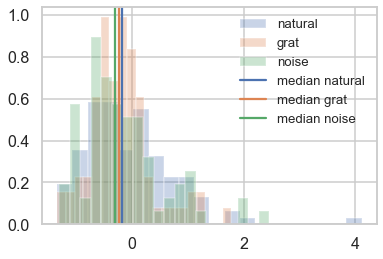

In [43]:
## bootstrap 20 out of 30 trials
'''
for each stim id, get resp_ad and resp_tg [ncell x trial_rep x nstim]
bootstrap select 20 trials out of trial_rep
sum over 20 trials to get resp & adp [ncell x nstim]
'''

def trial_rep_select(arr, n, seed=42):
    '''
    select 20 trials out of trial_rep
    arr: array to select from. shape [ncell x trial_rep]
    n: number of samples to select
    '''
    ntrial = arr.shape[1]
    np.random.seed(seed) # make sure R1 and R2 select the same trials!!
    idx = np.random.choice(ntrial, n, replace=True)
    return arr[:,idx]
    
# sum over 20 trials to get resp & adp [nstim x ncell]

seed = 42
R1_agg_stim = np.array([trial_rep_select(i, 20, seed=seed).sum(axis=1) for i in resp_ad_by_stim]) # sum over 20 trial reps
R2_agg_stim = np.array([trial_rep_select(i, 20, seed=seed).sum(axis=1) for i in resp_tg_by_stim])

adp_stim = (R2_agg_stim - R1_agg_stim) / (R1_agg_stim + 1e-7)
drop_perc = 0.5
if cell_filter_name == 'vis':
    drop_perc = 5
adp_stim[adp_stim < np.nanpercentile(adp_stim, drop_perc)] = np.nan
adp_stim[adp_stim > np.nanpercentile(adp_stim, 100-drop_perc)] = np.nan # drop extreme values of adp_stim (top and bottom x%)
print(adp_stim.shape)

plt.hist(adp_stim[:30, :].ravel(), bins=20, alpha=0.3, label='natural', density=True);
plt.hist(adp_stim[30:40, :].ravel(), bins=20, alpha=0.3, label='grat', density=True);
plt.hist(adp_stim[40:, :].ravel(), bins=20, alpha=0.3, label='noise', density=True);

plt.axvline(np.nanmedian(adp_stim[:30, :].ravel()), color='C0', label='median natural')
plt.axvline(np.nanmedian(adp_stim[30:40, :].ravel()), color='C1', label='median grat')
plt.axvline(np.nanmedian(adp_stim[40:, :].ravel()), color='C2', label='median noise')
plt.legend(frameon=False);

In [39]:
adp_stim.shape # nstim x ncell

df_adp_stim_nat = pd.DataFrame(adp_stim[:30, :].ravel(), columns=['adp'])
df_adp_stim_nat['stim_type'] = 'natural'
df_adp_stim_grat = pd.DataFrame(adp_stim[30:40, :].ravel(), columns=['adp'])
df_adp_stim_grat['stim_type'] = 'grating'
df_adp_stim_noise = pd.DataFrame(adp_stim[40:, :].ravel(), columns=['adp'])
df_adp_stim_noise['stim_type'] = 'noise'

df_adp_stim_type = pd.concat([df_adp_stim_nat, df_adp_stim_grat, df_adp_stim_noise])
df_adp_stim_type = df_adp_stim_type.dropna().reset_index(drop=True)
df_adp_stim_type['cell_filter_name'] = 'img_driven'
df_adp_stim_type

,adp,stim_type,cell_filter_name
0,-0.336700,natural,img_driven
1,-0.533882,natural,img_driven
2,1.558683,natural,img_driven
3,-0.551571,natural,img_driven
4,-0.310018,natural,img_driven
...,...,...,...
884,0.224938,noise,img_driven
885,-0.008038,noise,img_driven
886,-0.404522,noise,img_driven
887,-0.614972,noise,img_driven


In [45]:
df_adp_stim_nat = pd.DataFrame(adp_stim[:30, :].ravel(), columns=['adp'])
df_adp_stim_nat['stim_type'] = 'natural'
df_adp_stim_grat = pd.DataFrame(adp_stim[30:40, :].ravel(), columns=['adp'])
df_adp_stim_grat['stim_type'] = 'grating'
df_adp_stim_noise = pd.DataFrame(adp_stim[40:, :].ravel(), columns=['adp'])
df_adp_stim_noise['stim_type'] = 'noise'

df_adp_stim_type_pref = pd.concat([df_adp_stim_nat, df_adp_stim_grat, df_adp_stim_noise])
df_adp_stim_type_pref = df_adp_stim_type_pref.dropna().reset_index(drop=True)
df_adp_stim_type_pref['cell_filter_name'] = 'pref_filter'
df_adp_stim_type_pref

,adp,stim_type,cell_filter_name
0,-0.336700,natural,pref_filter
1,-0.533882,natural,pref_filter
2,-0.551571,natural,pref_filter
3,-0.310018,natural,pref_filter
4,-0.109388,natural,pref_filter
...,...,...,...
275,-1.077991,noise,pref_filter
276,-0.302880,noise,pref_filter
277,-0.988353,noise,pref_filter
278,-0.404522,noise,pref_filter


In [46]:
df_adp_stim_type = pd.concat([df_adp_stim_type, df_adp_stim_type_pref])
df_adp_stim_type

,adp,stim_type,cell_filter_name
0,-0.336700,natural,img_driven
1,-0.533882,natural,img_driven
2,1.558683,natural,img_driven
3,-0.551571,natural,img_driven
4,-0.310018,natural,img_driven
...,...,...,...
275,-1.077991,noise,pref_filter
276,-0.302880,noise,pref_filter
277,-0.988353,noise,pref_filter
278,-0.404522,noise,pref_filter


### boot adp for single cell by stim type

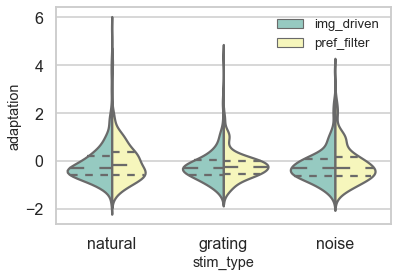

In [55]:
# # boxplot for df_adp_stim_type
# sns.boxplot(x='stim_type', y='adp', data=df_adp_stim_type, palette='Set2')
# plt.ylabel('adp');

# violinplot for df_adp_stim_type
sns.violinplot(x='stim_type', y='adp', data=df_adp_stim_type, 
               hue="cell_filter_name", split=True,
               palette='Set3', 
               inner="quartile",
               )
plt.ylabel('adaptation'); # calc from bootstraped single cell resp
# plt.ylim(-2, 2)
plt.legend(frameon=False, );

# # swarmplot for df_adp_stim_type
# plt.figure(figsize=(20, 4))
# sns.swarmplot(x='stim_type', y='adp', data=df_adp_stim_type, palette='Set2')
# plt.ylabel('adp');

C:\Users\ll357\AppData\Local\Temp\10\ipykernel_75956\2187926787.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_75956\2187926787.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


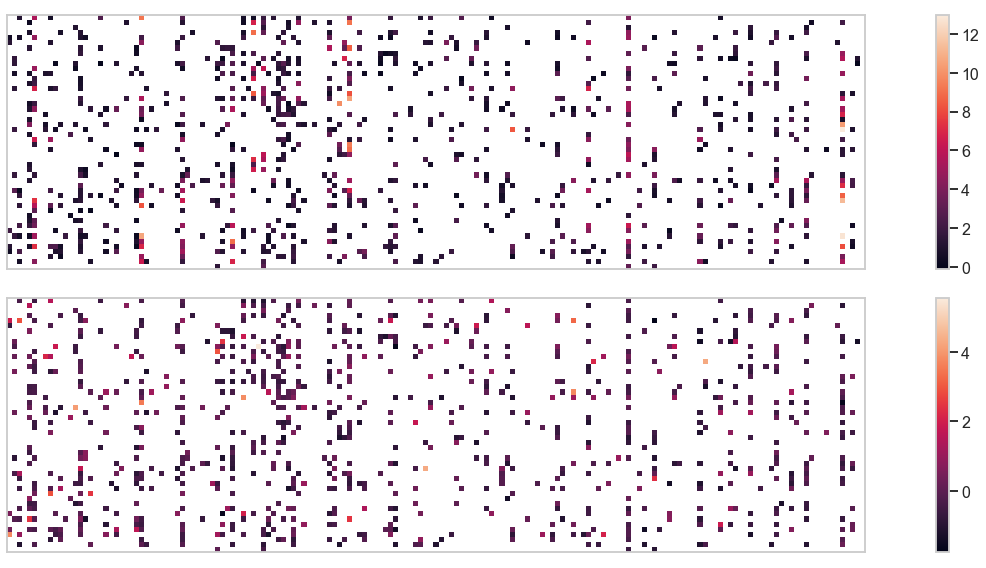

In [17]:
# resp matrix [nstim x ncell] w filter

plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.matshow(R1_agg_stim, fignum=False)
plt.xticks([]) # no axis ticks
plt.yticks([]);
plt.colorbar()

plt.subplot(2,1,2)
plt.matshow(adp_stim, fignum=False)
plt.xticks([]) # no axis ticks
plt.yticks([]);
plt.colorbar()
plt.tight_layout()

### boot adp for pop

In [376]:
resp_ad_by_stim[0].shape, len(resp_ad_by_stim) # ncell x ntrial_rep x nstim

def calc_adp_pop_boot_by_stim(resp_ad_by_stim, nboot=1000):
    '''calculate population adp by stim, with bootstrap sampling from trial reps'''
    
    adp_stim_boot = np.zeros((nboot, len(resp_ad_by_stim), resp_ad_by_stim[0].shape[0]))
    for iboot in np.arange(nboot):
        R1_agg_stim = np.array([trial_rep_select(irep, 20, seed=iboot).sum(axis=1) for irep in resp_ad_by_stim]) # sum over 20 trial reps
        R2_agg_stim = np.array([trial_rep_select(irep, 20, seed=iboot).sum(axis=1) for irep in resp_tg_by_stim])
        adp_stim = (R2_agg_stim - R1_agg_stim) / (R1_agg_stim + 1e-7)

        drop_perc = 0.5
        if cell_filter_name == 'vis':
            drop_perc = 3
        adp_stim[adp_stim < np.nanpercentile(adp_stim, drop_perc)] = np.nan
        adp_stim[adp_stim > np.nanpercentile(adp_stim, 100-drop_perc)] = np.nan # drop extreme values of adp_stim (top and bottom x%)
        adp_stim_boot[iboot] = adp_stim
    return adp_stim_boot

adp_stim_boot = calc_adp_pop_boot_by_stim(resp_ad_by_stim, nboot=1000)
adp_stim_boot.shape # nboot x nstim x ncell

(1000, 50, 169)

### boot adp pop vs spatial freq

In [377]:
cpd_array = np.round(np.geomspace(0.03, 0.9, num=10), 2)
noise_nbyn = [2,3,5,17, 6,10,34, 15,51,85] # from do_image_preprocess.py -> 2x2 grid to 85x85 grid
spatial_freq_cpd = list(cpd_array)

adp_stim_boot_pop = np.nanmean(adp_stim_boot, axis=2) # [nboot x nstim], avg over cells
adp_stim_pop_mean = np.nanmean(adp_stim_boot_pop, axis=0) # [nstim], avg over boot
adp_stim_pop_err = np.nanstd(adp_stim_boot_pop, axis=0)
adp_stim_pop_CI95 = np.nanpercentile(adp_stim_boot_pop, [2.5, 97.5], axis=0) # [2 x nstim], 95% CI

C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\1802988966.py:5: RuntimeWarning: Mean of empty slice
  adp_stim_boot_pop = np.nanmean(adp_stim_boot, axis=2) # [nboot x nstim], avg over cells
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\1802988966.py:6: RuntimeWarning: Mean of empty slice
  adp_stim_pop_mean = np.nanmean(adp_stim_boot_pop, axis=0) # [nstim], avg over boot
c:\Users\ll357\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ll357\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


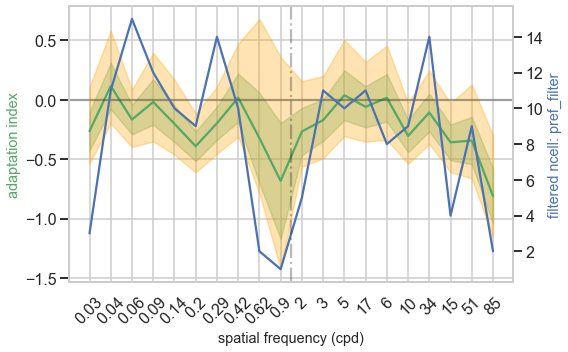

In [380]:
def plot_adp_by_SF(cell_filter, adp_stim_pop_mean, adp_stim_pop_CI95, adp_stim_pop_err):
    x = np.arange(len(adp_stim_pop_mean[30:]))
    y1 = adp_stim_pop_mean[30:]
    y2 = np.sum(cell_filter[:, 30:], axis=0)

    fig, ax1 = plt.subplots(figsize=(8,5))
    ax2 = ax1.twinx()

    ax1.plot(x, y1, 'g-')
    ax1.fill_between(x, y1-adp_stim_pop_err[30:], y1+adp_stim_pop_err[30:], alpha=0.3, color='g');
    ax1.fill_between(x, adp_stim_pop_CI95[0, 30:], adp_stim_pop_CI95[1, 30:], alpha=0.3, color='orange');
    ax1.axhline(0, color='k', linestyle='-', alpha=0.3)

    ax2.plot(x, y2, 'b-')
    ax2.axvline(len(x)//2 - 0.5, color='k', linestyle='-.', alpha=0.3)

    ax1.set_xlabel('spatial frequency (cpd)')
    ax1.set_xticks(x, list(spatial_freq_cpd) + list(noise_nbyn), rotation=45);
    ax1.set_ylabel('adaptation index', color='g')
    ax2.set_ylabel(f'filtered ncell: {cell_filter_name}', color='b')

    ax1.grid(True)
    ax2.grid(False) # grid off
    plt.tight_layout()
    plt.show()

plot_adp_by_SF(cell_filter, adp_stim_pop_mean, adp_stim_pop_CI95, adp_stim_pop_err)

#### bin SF
get more ncell preferring each SF

In [310]:
stim_id_mod = stim_id.copy()

stim_id_mod = np.array(stim_id_mod) # convert to array, otherwise bool index will not work!

stim_id_mod[stim_id_mod==31] = 32 # pretend stim #31 is stim #32: merge low SF gratings
stim_id_mod[stim_id_mod==39] = 38 # bin high SF gratings
stim_id_mod[stim_id_mod==40] = 38

stim_id_mod[stim_id_mod==41] = 42 # same for noise
stim_id_mod[stim_id_mod==49] = 48
stim_id_mod[stim_id_mod==50] = 48

np.unique(stim_id_mod), len(stim_id_mod) # stim id starts from 1!

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
        36, 37, 38, 42, 43, 44, 45, 46, 47, 48], dtype=int64),
 1473)

In [356]:
cell_filter_mod = cell_filter.copy()

cell_filter_mod[:, 31] = cell_filter_mod[:, 31] + cell_filter_mod[:, 30] # pretend cells who prefer stim #31 also prefer stim #32, take union
cell_filter_mod[:, 30] = 0 # remove stim #30
cell_filter_mod[:, 37] = cell_filter_mod[:, 37] + cell_filter_mod[:, 38]
cell_filter_mod[:, 38] = 0
cell_filter_mod[:, 37] = cell_filter_mod[:, 37] + cell_filter_mod[:, 39]
cell_filter_mod[:, 39] = 0

cell_filter_mod[:, 41] = cell_filter_mod[:, 41] + cell_filter_mod[:, 40]
cell_filter_mod[:, 40] = 0
cell_filter_mod[:, 47] = cell_filter_mod[:, 47] + cell_filter_mod[:, 48]
cell_filter_mod[:, 48] = 0
cell_filter_mod[:, 47] = cell_filter_mod[:, 47] + cell_filter_mod[:, 49]
cell_filter_mod[:, 49] = 0

cell_filter_mod[cell_filter_mod>1] = 1 # binarize cell_filter_mod

print(np.sum(cell_filter[:, 30:40], axis=0))
print(np.sum(cell_filter[:, 40:50], axis=0))
print(np.sum(cell_filter_mod[:, 30:], axis=0))

[ 3. 11. 15. 12. 10.  9. 14. 10.  2.  1.]
[ 5. 11. 10. 11.  8.  9. 14.  4.  9.  2.]
[ 0. 14. 15. 12. 10.  9. 14. 13.  0.  0.  0. 16. 10. 11.  8.  9. 14. 15.
  0.  0.]


In [357]:
resp_ad_by_stim, resp_tg_by_stim = resp_by_stim(resp_ad, resp_tg, cell_filter_mod, stim_id_mod)
adp_stim_boot = calc_adp_pop_boot_by_stim(resp_ad_by_stim, nboot=1000)
print(adp_stim_boot.shape, resp_ad_by_stim[0].shape, resp_ad_by_stim.__len__())

spatial_freq_cpd = np.round(np.geomspace(0.03, 0.9, num=10), 2)
spatial_freq_cpd = spatial_freq_cpd[1:-2] # remove lowest & 2 highest SF
noise_nbyn = [2,3,5,17, 6,10,34, 15,51,85] # from do_image_preprocess.py -> 2x2 grid to 85x85 grid
noise_nbyn = noise_nbyn[1:-2]

cell_filter_mod = np.delete(cell_filter_mod, [30, 38, 39, 40, 48, 49], axis=1) # remove merged stim

adp_stim_boot_pop = np.nanmean(adp_stim_boot, axis=2) # [nboot x nstim], avg over cells
adp_stim_pop_mean = np.nanmean(adp_stim_boot_pop, axis=0) # [nstim], avg over boot
adp_stim_pop_err = np.nanstd(adp_stim_boot_pop, axis=0)
adp_stim_pop_CI95 = np.nanpercentile(adp_stim_boot_pop, [2.5, 97.5], axis=0) # [2 x nstim], 95% CI

(1000, 44, 169) (169, 30) 44


C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\1863290817.py:12: RuntimeWarning: Mean of empty slice
  adp_stim_boot_pop = np.nanmean(adp_stim_boot, axis=2) # [nboot x nstim], avg over cells
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\1863290817.py:13: RuntimeWarning: Mean of empty slice
  adp_stim_pop_mean = np.nanmean(adp_stim_boot_pop, axis=0) # [nstim], avg over boot
c:\Users\ll357\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ll357\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


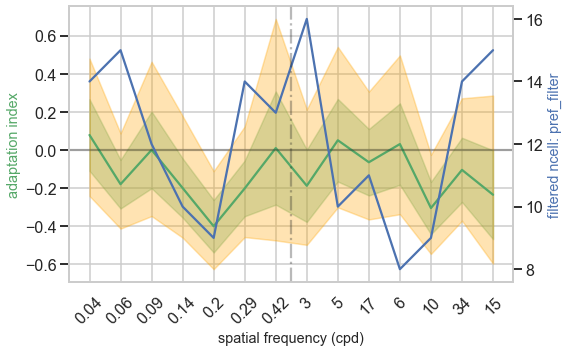

In [364]:
plot_adp_by_SF(cell_filter_mod, adp_stim_pop_mean, adp_stim_pop_CI95, adp_stim_pop_err)

### boot adp for single cell
#### sort cell by adp

C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\3884612759.py:2: RuntimeWarning: Mean of empty slice
  adp_stim_cell = np.nanmean(adp_stim_boot, axis=0) # [nstim x ncell], avg over boot
c:\Users\ll357\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\3884612759.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(fraction=0.015, pad=0.04)


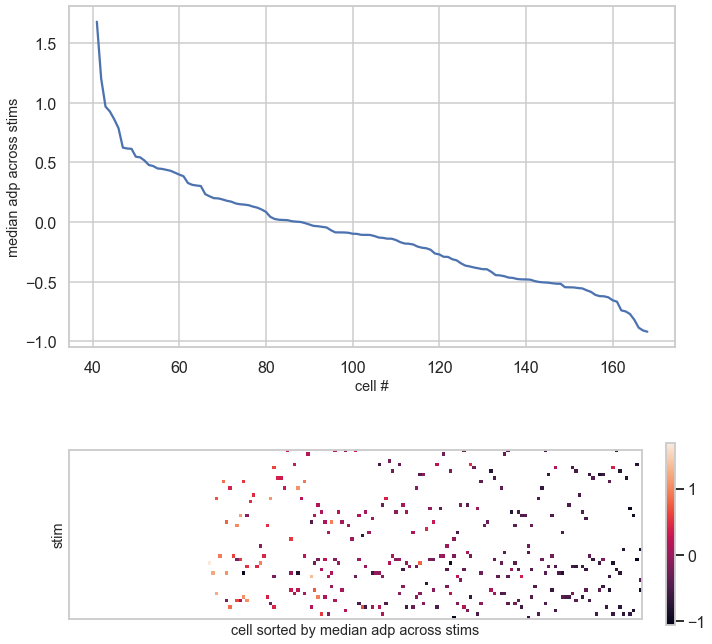

In [182]:
adp_stim_boot.shape # nboot x nstim x ncell
adp_stim_cell = np.nanmean(adp_stim_boot, axis=0) # [nstim x ncell], avg over boot
# plt.matshow(adp_stim_cell);
# plt.colorbar();

# sort cells by overall adp across stims
adp_stim_cell_mean = np.nanmedian(adp_stim_cell, axis=0) # [ncell], avg over stims
adp_stim_cell_order = np.argsort(adp_stim_cell_mean)[::-1] # sort in descending order

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.sort(adp_stim_cell_mean)[::-1]);
plt.xlabel('cell #')
plt.ylabel('median adp across stims')

plt.subplot(2,1,2)
im = plt.imshow(adp_stim_cell[:, adp_stim_cell_order])
plt.grid(False)
plt.colorbar(fraction=0.015, pad=0.04)

plt.xlabel('cell sorted by median adp across stims')
plt.ylabel('stim')
plt.xticks([]) # no axis ticks
plt.yticks([])
plt.tight_layout()

# resp

In [184]:
resp_ad_by_stim[0].shape, len(resp_ad_by_stim) # ncell x ntrial_rep x nstim
resp_ad_stim_cell = np.array([i.sum(axis=1) for i in resp_ad_by_stim]) # [ncell x nstim], sum over trial reps
resp_ad_stim_cell.shape # nstim x ncell

# plt.matshow(resp_ad_stim_cell)
# plt.grid(False)
# plt.xlabel('cell')
# plt.ylabel('stim')
# plt.colorbar();

(50, 169)

### pref stim 
take only cells preferring stim  
assume cells prefer 1 natural img, 1 grat, 1 noise (1 preferred stim among each stim type)  
using resp of img driven cells only

In [187]:
# print(resp_ad_stim_cell.shape) # nstim x ncell

R1_by_type = {}
R1_by_type['nat'] = resp_ad_stim_cell[:30]
R1_by_type['grat'] = resp_ad_stim_cell[30:40]
R1_by_type['noise'] = resp_ad_stim_cell[40:]
# print(R1_by_type['nat'].shape, R1_by_type['grat'].shape, R1_by_type['noise'].shape)

pref_stim_by_type = {}
stim_offset = 0
for itype, resp_matrix in R1_by_type.items():
    
    # pref_stim = np.argmax(resp_matrix, axis=0) + stim_offset # for each cell, get peak resp stim. can't nanargmax due to All-NaN slice
    pref_stim = np.ones((resp_matrix.shape[1], 1)) * np.pi
    for icell in np.arange(resp_matrix.shape[1]):
        resp_cell = resp_matrix[:, icell]
        try:
            pref_stim[icell] = np.nanargmax(resp_cell) + stim_offset
        except:
            pref_stim[icell] = np.nan # if cell not responsive to any stim in this stim type, set pref stim to nan
    pref_stim = [elem[0] for elem in pref_stim]
    pref_stim = np.array(pref_stim)

    # print(pref_stim.shape) # ncell
    pref_stim_by_type[itype] = pref_stim
    stim_offset = stim_offset + resp_matrix.shape[0]

nat
(array([ 0.,  1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 11., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 28., 29.,
       nan]), array([ 8,  3,  1,  6,  5,  5,  6,  5,  5,  6,  2,  5,  1,  6,  4,  8,  8,
        2,  7,  6,  1,  5,  1,  3,  3,  2, 55], dtype=int64))
grat
(array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39., nan]), array([ 3, 11, 15, 12, 10,  9, 14, 10,  2,  1, 82], dtype=int64))
noise
(array([40., 41., 42., 43., 44., 45., 46., 47., 48., 49., nan]), array([ 5, 11, 10, 11,  8,  9, 14,  4,  9,  2, 86], dtype=int64))


<BarContainer object of 3 artists>

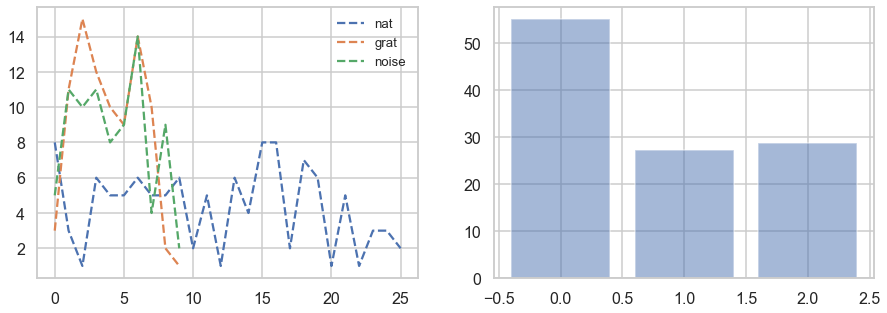

In [188]:
# how many cells prefer each stim?
for itype, pref_stim in pref_stim_by_type.items():
    print(itype)
    print(np.unique(pref_stim, return_counts=True)) # count elements in pref_stim

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), )

for itype, pref_stim in pref_stim_by_type.items():
    ax1.plot(np.unique(pref_stim, return_counts=True)[1][:-1], label=itype, linestyle='--')
ax1.legend(frameon=False)

ax2.bar(np.arange(3), [55, 82/3, 86/3], alpha=0.5)
# ax2.legend(frameon=False)

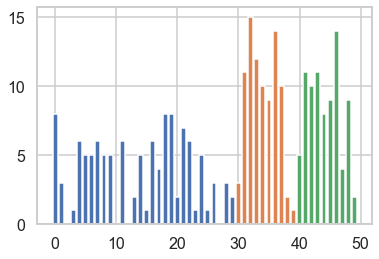

In [190]:
# pref_filter: which cell prefer which stim
nstim = resp_ad_stim_cell.shape[0]
ncell = resp_ad_stim_cell.shape[1]
pref_filter = np.zeros((nstim + 1, ncell)) # padding 1 row at the bottom for nan

for itype, pref_stim in pref_stim_by_type.items():
    pref_stim[np.isnan(pref_stim)] = nstim # set nan to last row
    pref_stim_int = [int(elem) for elem in pref_stim]
    pref_filter[pref_stim_int, np.arange(ncell)] = 1

pref_filter = pref_filter[:-1, :] # remove padding row. same format as img_driven: bool mat of nstim x ncell
# plt.matshow(pref_filter);
# np.save(os.path.join(data_dir, 'pref_filter.npy'), pref_filter)

# how many cells prefer each stim?
ncell_pref_stim = pref_filter.sum(axis=1) # nstim
plt.bar(np.arange(30), ncell_pref_stim[:30]);
plt.bar(np.arange(30, 40), ncell_pref_stim[30:40]);
plt.bar(np.arange(40, 50), ncell_pref_stim[40:]);

## sort cells by overall resp across stims

c:\Users\ll357\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\4011642145.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(fraction=0.015, pad=0.04)


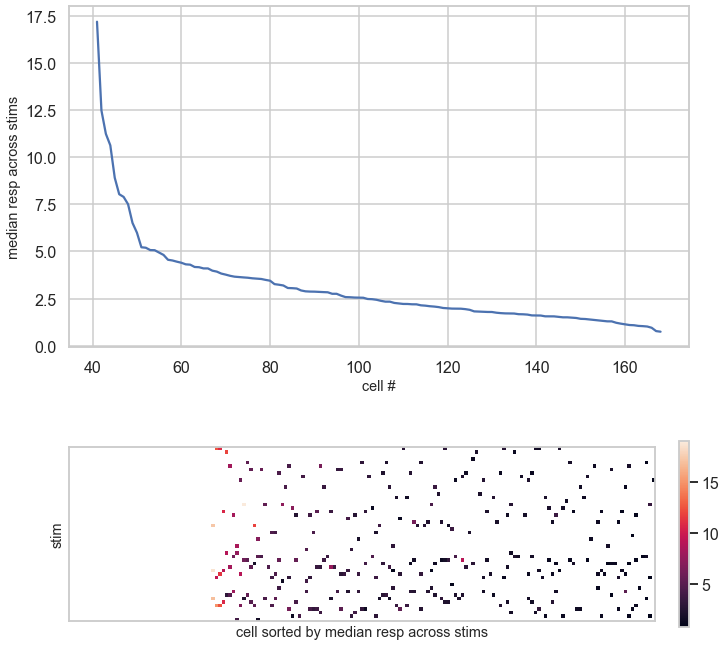

In [192]:
# sort cells by overall resp across stims

resp_ad_stim_cell_agg = np.nanmedian(resp_ad_stim_cell, axis=0) # [ncell], avg over stims
resp_ad_stim_cell_order = np.argsort(resp_ad_stim_cell_agg)[::-1] # sort in descending order

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.sort(resp_ad_stim_cell_agg)[::-1]);
plt.xlabel('cell #')
plt.ylabel('median resp across stims')

plt.subplot(2,1,2)
plt.imshow(resp_ad_stim_cell[:, resp_ad_stim_cell_order])
plt.grid(False)
plt.colorbar(fraction=0.015, pad=0.04)

plt.xlabel('cell sorted by median resp across stims')
plt.ylabel('stim')
plt.xticks([]) # no axis ticks
plt.yticks([])
plt.tight_layout()

## sort stims by overall resp across cells

c:\Users\ll357\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\547715457.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


([], [])

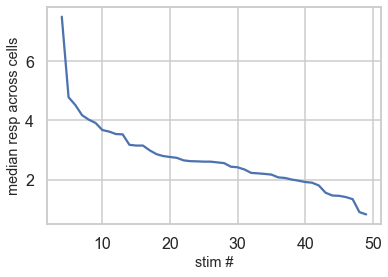

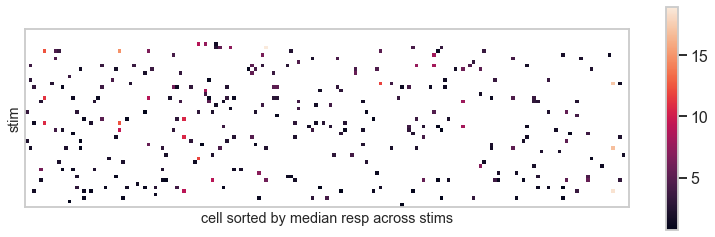

In [193]:
# sort stims by overall resp across stims

resp_ad_stim_cell_agg = np.nanmedian(resp_ad_stim_cell, axis=1) # [nstim], avg over cells
resp_ad_stim_cell_order = np.argsort(resp_ad_stim_cell_agg)[::-1] # sort in descending order
resp_ad_stim_cell_order

plt.plot(np.sort(resp_ad_stim_cell_agg)[::-1]);
plt.xlabel('stim #')
plt.ylabel('median resp across cells')

plt.matshow(resp_ad_stim_cell[resp_ad_stim_cell_order, :])
plt.grid(False)
plt.colorbar()
plt.xlabel('cell sorted by median resp across stims')
plt.ylabel('stim')
plt.xticks([]) # no axis ticks
plt.yticks([])
# plt.tight_layout()

## sort cells by tuning curve
there is no good tuning curve for mix50 stim

c:\Users\ll357\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


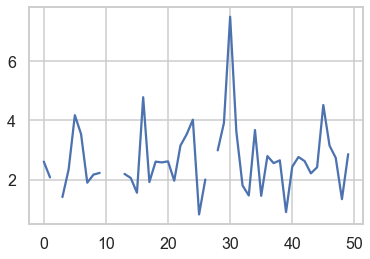

In [194]:
resp_stim = np.nanmedian(resp_ad_stim_cell, axis=1) # avg over cells
plt.plot(resp_stim);

In [203]:
ncell = resp_ad_stim_cell.shape[1]
nstim = resp_ad_stim_cell.shape[0]
resp_ad_sorted = resp_ad_stim_cell[resp_ad_stim_cell_order, :]

# TODO: fix this when img_driven_only == True

In [210]:
resp_ad_sorted.shape
# resp_ad_stim_cell_order

(50, 169)

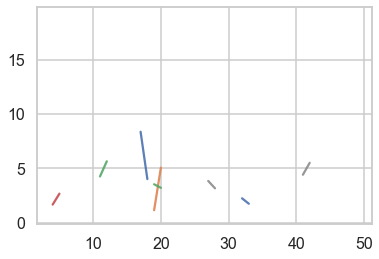

In [211]:
for icell in np.arange(ncell):
    plt.plot(resp_ad_sorted[:, icell], label=icell, alpha=0.9)
# plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\370873811.py:14: RuntimeWarning: All-NaN slice encountered
  ymin = np.nanmin(resp_ad_sorted[:, icell])
C:\Users\ll357\AppData\Local\Temp\10\ipykernel_51616\370873811.py:15: RuntimeWarning: All-NaN slice encountered
  ymax = np.nanmax(resp_ad_sorted[:, icell])


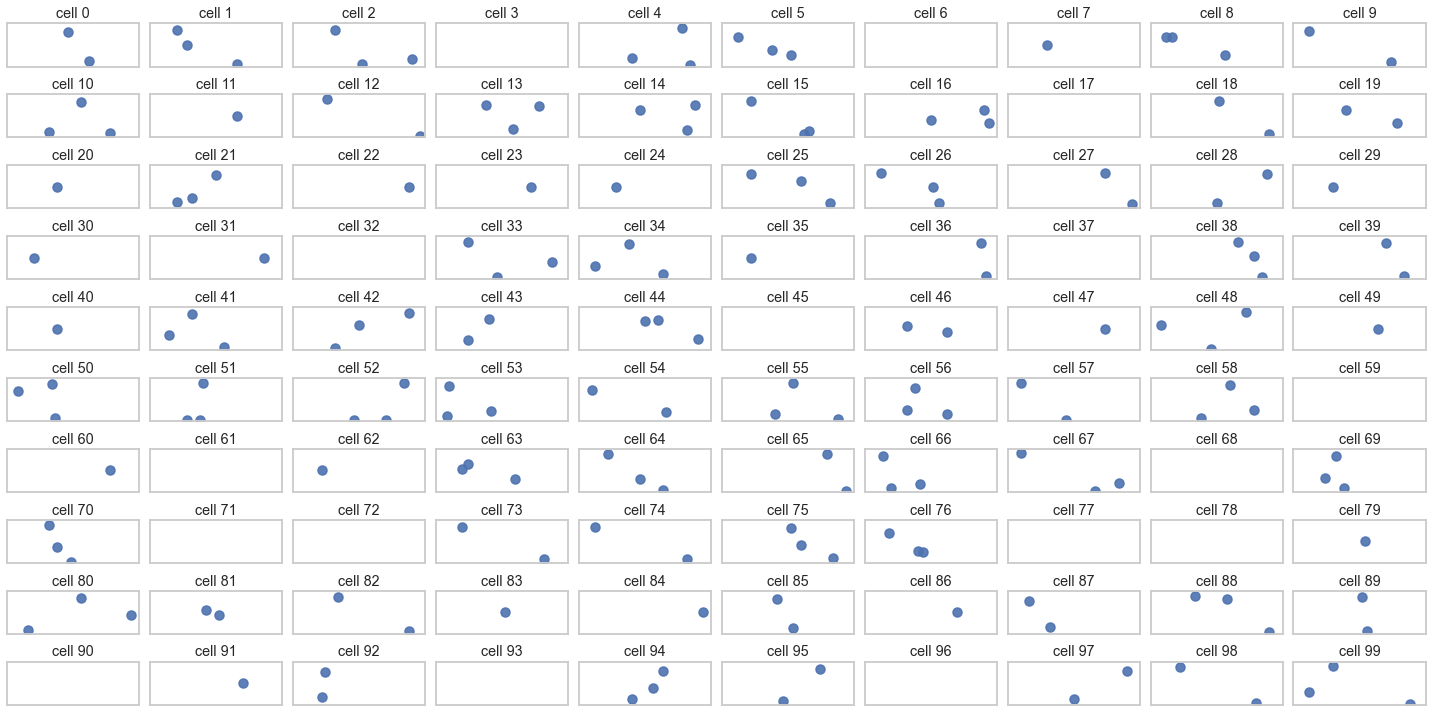

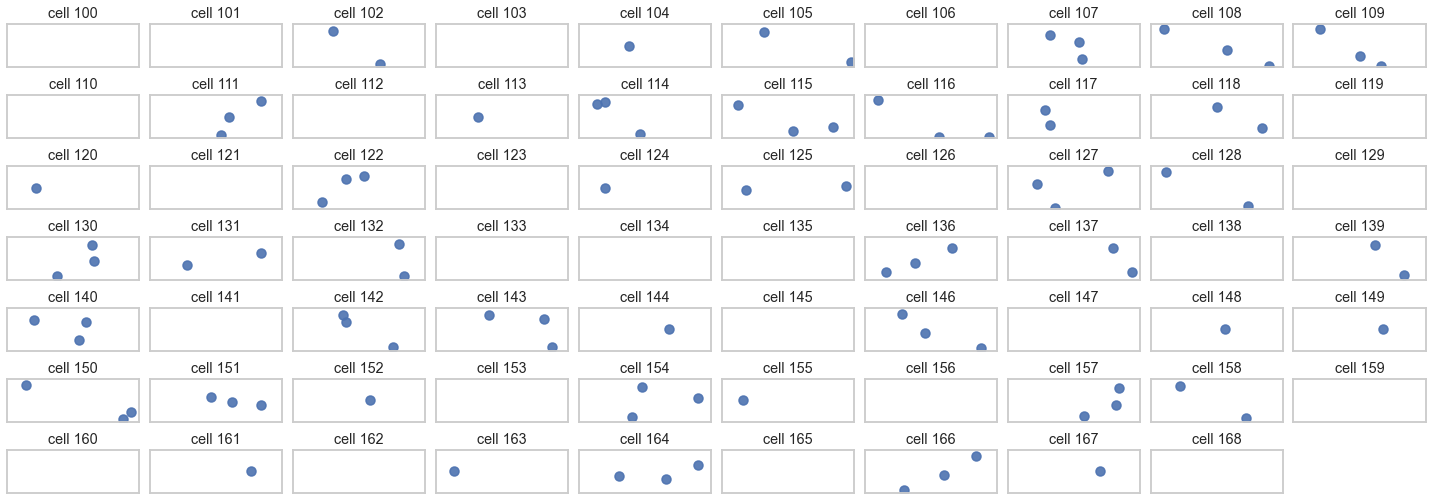

In [219]:
# single cell tuning curve
nrow = 10
ncol = 10
nplot = nrow * ncol
nfig = int(np.ceil(ncell / nplot))

for ifig in np.arange(nfig):
    plt.figure(figsize=(20,10))
    for iplot in np.arange(nplot):
        icell = ifig * nplot + iplot
        if icell < ncell:
            plt.subplot(nrow, ncol, iplot+1)
            x = np.arange(len(resp_ad_sorted[:, icell]))
            ymin = np.nanmin(resp_ad_sorted[:, icell])
            ymax = np.nanmax(resp_ad_sorted[:, icell])
            plt.scatter(x, resp_ad_sorted[:, icell], label=icell, alpha=0.9) # plt.plot for img driven filter. scatter for pref filter
            plt.xticks([])
            plt.yticks([])
            plt.xlim([0, nstim])
            try:
                plt.ylim([ymin*0.9, ymax*1.1])
            except:
                pass
            plt.grid(False)
            # plt.xlabel('stim')
            # plt.ylabel('resp')
            plt.title('cell %d' % icell)
    plt.tight_layout()

# pop resp or adp by stim type
regroup into stim type to get resp & adp [ncell x nstim_type]  

In [58]:
resp_ad_by_stim.__len__(), resp_ad_by_stim[0].shape


NameError: name 'resp_ad_cell' is not defined